# UW-Madison GI Tract Image Segmentation
Ahmed Sayed
#### Summary
The problem we are working on is a multiclass image segmentation problem for MRI medical images.
The problem is from a current active contest on Kaggle: https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation
The report will be semi-formal as it will also include the problems I faced, alternatives I used, and errors I got.
The report is is done on 2 parts locally and on google colab due to GPU issues when training model


### Domain Background
An estimate of 5 million people per year are diagnosed with 
gastro-intestinal tract cancer. Half of these patients are eligible for radiation therapy. Usually, the radiation therapy takes 10->15 minutes a day from 1->6 weeks. Radiation oncologists try to deliver high doses of radiation using X-Ray beams. These beams are focused on the tumors while avoiding the stomach and the intestines. With technologies such as MRI and MR-Linacs, radiation oncologists can visualize the daily position of the intestines and tumors as their positions are changing daily. In every setting, the oncologist must outline the position of the stomach and intestines manually to avoid them while delivering the dose possible with the X-Ray beam on the tumor. 

### Problem statement
The process of manually outlining the position of the intestines and stomach prolongs each session from possibly 10-15 minutes to more than 1 hour. Such a long waiting time may be harmful to the patient, slows down the efficiency, causes doctor to have a labour intensive repetitive work daily instead of focusing on the main task which is guiding the X-Ray beam. 


### Proposed solution
The solution is to create a model to automatically segment the stomach and intestines using over 3 GB of MRI images from actual cancer patients.


In [ ]:
!pip install segmentation-models-pytorch
!pip install colorama

In [1]:
# Libraries
from collections import defaultdict
import copy
import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
import cv2
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import torch.optim as optim
import torchvision
import segmentation_models_pytorch as smp
import gc
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings("ignore")

###### Data Exploration
Data Consists of 3 columns ( id - class - segmentation ) and 115488 rows. Every 3 rows belong to 1 picture difference is only the segmentation class each row has:
- id: Consists of a string that includes the id of person doing the MRI, the day the MRI has been done on, the number of the image that was taken in the setting.
- class: Classifies the label of the segmentation.
- segmentation: Contains pairs of pixel location and how much pixels next it is belong to the mask.

In [2]:
# loading metadata
train_dir = "train"
training_metadata_path = "train.csv"

train_df = pd.read_csv(training_metadata_path)
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


Source Used as reference for data preparation: https://www.kaggle.com/code/sagnik1511/uwmgit-data-preparation-from-scratch

In [7]:
#Dividing the id column to case, Day and Slice columns
train_df["case"] = train_df["id"].apply(lambda x: int(x.split("_")[0][4:]))
train_df["day"] = train_df["id"].apply(lambda x: int(x.split("_")[1][3:]))
train_df["slice"] = train_df["id"].apply(lambda x: int(x.split("_")[-1]))
train_df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


Created a new Dataframe to merge every 3 rows into one, save meta data of images and the path to images:
- large_bowel: Segmentation of large bowel
- small_bowel: Segmentation of small bowel
- stomach: Segmentation of stomach
- height: Height of the image as the height differs from image to image
- width: Width of the image as the width differs from image to image
- path: String path to image

In [ ]:
# Creating Empty Dataframe and merging every 3 rows
df = pd.DataFrame(columns=["id", "case", "day", "slice", "large_bowel", "small_bowel", "stomach", "height", "width", "path"])
row = -1
for i in range(train_df.shape[0]):
    if (i % 3 == 0):
        row += 1
        df.loc[row,"id"] = train_df.loc[i,"id"]
        df.loc[row,"case"] = train_df.loc[i,"case"]
        df.loc[row,"day"] = train_df.loc[i,"day"]
        df.loc[row,"slice"] = train_df.loc[i,"slice"]
        df.loc[row,"large_bowel"] = train_df.loc[i,"segmentation"]
    elif (i % 3 == 1):
        df.loc[row,"small_bowel"] = train_df.loc[i,"segmentation"]
    else:
        df.loc[row,"stomach"] = train_df.loc[i,"segmentation"]
        

# Getting list of all images available in train folder
images_list = glob('train/*/*/*/*.png')


# Segmenting the images path to connect them to the correct row based on Case, Day, Slice
for i, image_path in enumerate(images_list):
    segment= image_path.split("_")
    case = int(segment[0].split("\\")[2].replace("case",""))
    day = int(segment[1].split("\\")[0].replace("day",""))
    part = int(segment[2])
    height = int(segment[3])
    width = int(segment[4])
    index = df.index[(df['case'] == case) & 
                     (df['day'] == day) & 
                     (df['slice'] == part)].tolist()
    df.loc[index[0], "height"] = int(height)
    df.loc[index[0], "width"] = int(width)
    df.loc[index[0], "path"] = image_path

In [ ]:
# Saving generated dataframe
df.to_csv('top_df.csv', index = 0)

In [10]:
# Reading new Dataframe
df= pd.read_csv("top_df.csv")
df['width'] = df['width'].astype(int)
df['height'] = df['height'].astype(int)
df['small_bowel'] = df['small_bowel'].fillna("")
df['large_bowel'] = df['large_bowel'].fillna("")
df['stomach'] = df['stomach'].fillna("")
# Creating count column to filter rows with no segmentation in any of the three categories
df['count'] = np.nan
df['count'] = np.sum(df.iloc[:,4:7]!='',axis=1).values
df.head()

,id,case,day,slice,large_bowel,small_bowel,stomach,height,width,path,count
0,case123_day20_slice_0001,123,20,1,,,,266,266,train\case123\case123_day20\scans\slice_0001_2...,0
1,case123_day20_slice_0002,123,20,2,,,,266,266,train\case123\case123_day20\scans\slice_0002_2...,0
2,case123_day20_slice_0003,123,20,3,,,,266,266,train\case123\case123_day20\scans\slice_0003_2...,0
3,case123_day20_slice_0004,123,20,4,,,,266,266,train\case123\case123_day20\scans\slice_0004_2...,0
4,case123_day20_slice_0005,123,20,5,,,,266,266,train\case123\case123_day20\scans\slice_0005_2...,0


Plotting the MRI images 
Source used as reference: https://www.kaggle.com/code/subinek/detailed-data-visualization-for-beignners?scriptVersionId=93490470&cellId=13

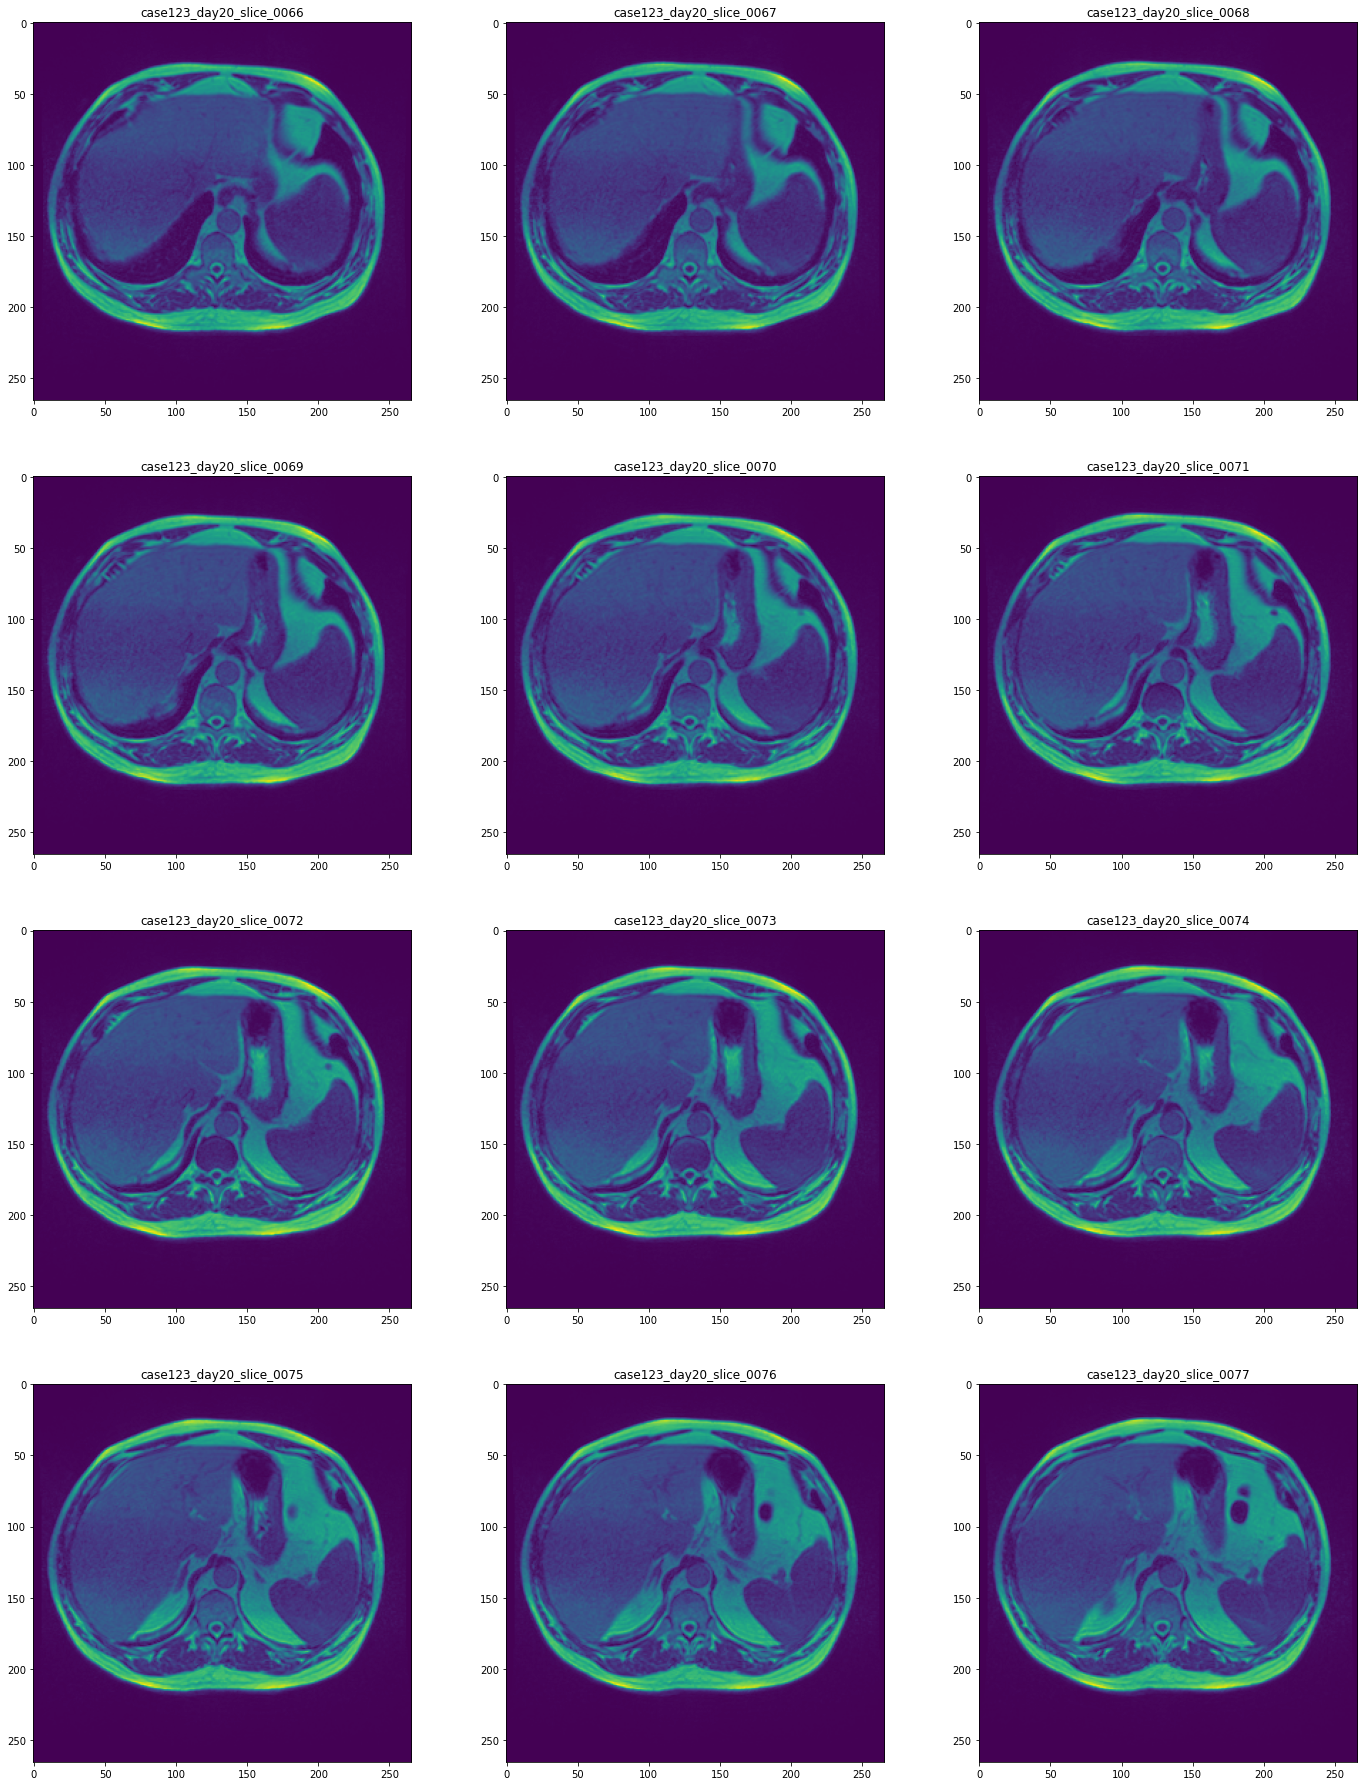

In [11]:
# Plotting the MRI images
plt.subplots(figsize=(24,32))
y = 65
for i in range(12):
    index = y
    y += 1
    image = np.array(Image.open(df.loc[index, 'path']))
    #print(df.loc[index, 'path'])
    plt.subplot(4,3,i+1)
    title = (df.loc[index, 'id'])
    plt.title(title)
    plt.imshow(image)
    #plt.imshow(np.interp(image, [np.min(image), np.max(image)], [0,255]))
plt.show()

Created a function to take the string from stomach, large_bowel, smal_bowel columns and give a make output and works as following:
- Take input string then split it based on space char
- Create a numpy array of 0 with the length of Height of image multiply its Width. So it can be reshaped to fit image perfectly
- For loop with indexing of +2 each loop, where i is pixel location and i+1 is number of pixels horizontally after i location.
- Append the pixel numbers to a list called pixel_positions
- Change values in the numpy array to 1 with indexes corrosponding to values saved in pixel_positions list
- Reshaping array to the shape of the image

In [12]:
def rle_decode(mask_string, width, height, dimention = 1, color = 1):
    #split 
    segment = mask_string.split(' ')
    pixel_pair_list = []
    mask_array = np.zeros(height * width, dtype=np.float32)
    if (mask_string != ""):
        for pair_value in segment:
            pixel_pair_list.append(int(pair_value))
        pixels_positions = []    #   Pixel Locations
        # for loop moving by 2 positions first is pixel location, second is length after it
        # assigning location in an array before reshaping it to a matrix
        for i in range(0,len(pixel_pair_list),2):
            for pixel_position in range(pixel_pair_list[i],pixel_pair_list[i] + pixel_pair_list[i+1]):
                pixels_positions.append(pixel_position)
        mask_array[pixels_positions] = 1
    return mask_array.reshape(width, height, dimention)


Kept Searching for a visualisation method to show legend for multiclass segmentation then found this code. I adjusted the code to fit my dataframe then plotted the output.

Testing the rle_decode function and getting a prespective of the masks on the image
source used as reference: https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda?scriptVersionId=94128751&cellId=12

Text(0.5, 0.98, '')

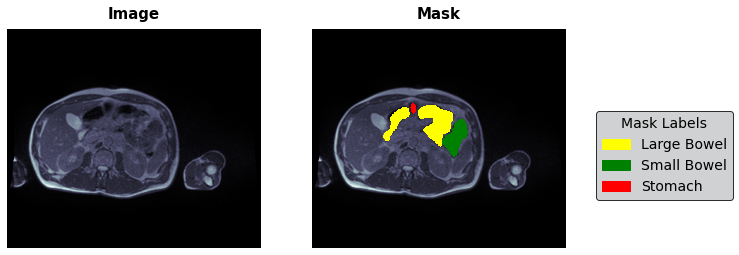

In [13]:
index = df.index[df['id'] == "case129_day27_slice_0089"].tolist()
sample_path = df.loc[index,'path'].values[0]
sample_img = cv2.imread(sample_path, cv2.IMREAD_ANYDEPTH)

w=df.loc[index,'width'].values[0]
h=df.loc[index,'height'].values[0]

mask1=rle_decode(df.loc[index,'small_bowel'].values[0], w, h, 1)
mask2=rle_decode(df.loc[index,'large_bowel'].values[0],w, h, 1)
mask3=rle_decode(df.loc[index,'stomach'].values[0],w, h, 1)


fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
im = ax0.imshow(sample_img, cmap='bone')
ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)


colors1 = ['yellow']
colors2 = ['green']
colors3 = ['red']

cmap1 = mpl.colors.ListedColormap(colors1)
cmap2 = mpl.colors.ListedColormap(colors2)
cmap3= mpl.colors.ListedColormap(colors3)

l0 = ax1.imshow(sample_img, cmap='bone')
l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)



_ = [ax.set_axis_off() for ax in [ax0,ax1]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')
plt.suptitle("", fontsize=20, weight='bold')

### Current lower cells are on google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the current part the variables are selected not scientifically due to many reasons in order:
- My graphics card always ran out of memory even in the first batch, tried debugging for almost a week to no avail.
- Switched to Google Colab.
- Any more than BATCH_SIZE of 8 will cause to run out of memory on google colab.
- Any more than NUM_EPOCHS of 5 will cause me to run out of time on my free Runtime on google colab GPU and i have to wait 2 days to re-run the code.

By no means those variables are optimized but its the heighest i could run with my current resources.

In [4]:
c_  = Fore.GREEN
sr_ = Style.RESET_ALL


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
NUM_EPOCHS = 5
#n_accumulate  = max(1, 32//BATCH_SIZE)
scaler = torch.cuda.amp.GradScaler()

#### Data Loader
Data Loader consists of several functions which  are:
- __init__: which is the constructor, used only to take the dataset and save it in the class


- __len__: to return length of dataset


- __getitem__: It is the main function of the class and it returns the Image tensor and the mask tensor. It consists of the following steps
 - Getting image path, width and height from dataframe
 - Getting 3 masks corrosponding to stomach and the intestines
 - Using OpenCv to the resize the mask using the interpolation INTER_AREA. Based on OpenCv "To shrink an image, it will generally look best with CV_INTER_AREA interpolation, whereas to enlarge an image, it will generally look best with CV_INTER_CUBIC (slow) or CV_INTER_LINEAR (faster but still looks OK).", the source: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#void%20resize(InputArray%20src,%20OutputArray%20dst,%20Size%20dsize,%20double%20fx,%20double%20fy,%20int%20interpolation)
 - Appending the 3 masks to one array to train them together and to have same dimention as the image
 - Return tensors
 
 
- __Load_image__: Function used to call the image and return a tensor of it, It consists of the following steps:
 - Read image
 - Do minmax normalization then multiply the image by 255 so the image can be clearer, dark darker and light lighter.
 - resize the image shape
 - Using torch.tile to convert the image from Gray to RGB, However not sure if i need to do so. In further tests will keep the 3rd dimention size 1 instead of 3 and will test the results.
 - Nomalize the image by dividing it by 255
 - Return tensor
 
 
In Data loader i abstained from using albumentations. The images them selfs are in a very contrained environment as the process of taking an MRI image requires the patient to be in a certain pose and not deviate from it.

Source used as reference for the code: https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-pytorch-train-with-eda?scriptVersionId=94647641&cellId=24

In [6]:
class Dataload(Dataset):
    def __init__(self, df, subset = None, transform = None):

        self.df = df
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = "/content/drive/MyDrive/"+self.df.loc[index,'path']

        #image_path=self.df['path'].iloc[index]
        h = self.df.loc[index,'height']
        w = self.df.loc[index,'width']
        
        mask1 = rle_decode(self.df.loc[index,'stomach'], w, h)
        mask2 = rle_decode(self.df.loc[index,'small_bowel'], w, h)
        mask3 = rle_decode(self.df.loc[index,'large_bowel'], w, h)
        
        mask1 = cv2.resize(mask1, (256, 256), interpolation = cv2.INTER_AREA)
        mask2 = cv2.resize(mask2, (256, 256), interpolation = cv2.INTER_AREA)
        mask3 = cv2.resize(mask3, (256, 256), interpolation = cv2.INTER_AREA)
        
        masks = []
        masks.append(mask1)
        masks.append(mask2)
        masks.append(mask3)
        
        image = self.load_image(image_path)
        return torch.tensor(image), torch.tensor(masks)
#         
        
        
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = (image - image.min())/(image.max() - image.min())*255.0 
        image = cv2.resize(image, (256, 256))

        image = np.tile(image, [3, 1, 1]) # gray to rgb
        image = image.astype(np.float32) /255.
        return image

#### UNet
I decided for the first architecture i would use is UNet. UNet is a semantic segmentation technique originally proposed for medical imaging segmentation. It is also very widely used and is used in many research papers. That is the main reason i selected this as my first model.

I had many problems using UNet as the ready made libraries for UNet either lacked documentation or didn't work with my inputs for some reason and i couldn't debug the errors. I followed a tutorial re-creating the originial UNet Model from research paper and explaining it. After finishing the tutorial i still had some errors but i fixed it by adding a padding of 1 to my Conv2d, the error probably resulted from difference in the input size and that lead to when cropping the image it found nothing to crop or wrong dimentions. And just added BatchNorm2d after each Conv2d.

Source of UNet tutorial: https://www.youtube.com/watch?v=u1loyDCoGbE&ab_channel=AbhishekThakur

#### DeeplapV3+
I decided on this architectire because it was used in many medical images research papers. It also shares the many properties of UNet as it is an Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation. The model Used is ready made model in segmentation_models_pytorch library.

In [7]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
#         nn.Conv2d(in_c, out_c, kernel_size = 3,),
#         nn.ReLU(inplace = True),
#         nn.Conv2d(out_c, out_c, kernel_size = 3),
#         nn.ReLU(inplace = True),
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace = True),
    )
    return conv


def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta//2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]
    

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #Going down part
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)    
        self.down_conv_3 = double_conv(128, 256)    
        self.down_conv_4 = double_conv(256, 512)    
        self.down_conv_5 = double_conv(512, 1024)
        
        #Going up Part
        self.up_trans_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        self.up_conv_2 = double_conv(512, 256)
        
        self.up_trans_3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 1)
        
# Does for 1 image per time
    def forward(self, image):
        #encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        #decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        x = self.out(x)
        return x

#### Criterion
BCEWithLogitsLoss is a cross entropy loss that comes inside a sigmoid function. After searching it seems this algorithm is the best loss function for multiclass image Segmentation as suggested by professionals in this source: https://discuss.pytorch.org/t/loss-function-for-multi-class-semantic-segmentation/40596

In [17]:
criterion = nn.BCEWithLogitsLoss()

#### Metrics
There are several metrics to use Based on the source provided below the best are either use Jaccard or Dice for evaluation Metric instead of just accuracy of pixels. since the segmentated area is small compared to total mask size. And i went with using Jaccard function.

Source : https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [20]:
def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):

    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

#### Training function
The function has 4 inputs:
 - Loader: Which is the training dataloader
 - model: Which is either UNet or DeepLapV3
 - Optimizer: Adam
 - Scaler : GradScaler. Which helps to perform the steps of gradient scaling conveniently. 


The training function gets the batch masks and images with every loop iteration, then calculate the loss using BCEWithLogitsLoss function, then do backward propagation. Then calculate loss of the entire epoch then show it in the progress bar of tqdm library which allows to progress in many ways and edit some properties of it.

Sources used: 
- https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson

- https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-pytorch-train-with-eda

In [18]:
def train_fn(loader, model, optimizer, scaler):
    model.train()
    loop = tqdm(loader)
    dataset_size = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Train ')
    for batch_index, (images, masks) in pbar:
        images = images.to(DEVICE, dtype=torch.float)
        masks  = masks.to(DEVICE, dtype=torch.float)

        #forward
        with torch.cuda.amp.autocast():
            predictions = model(images)
            loss = criterion(predictions, masks)
            

        # backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        running_loss += (loss.item() * BATCH_SIZE)
        dataset_size += BATCH_SIZE
        epoch_loss = running_loss / dataset_size
        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

#### Validation function
The function has 4 inputs:
 - Loader: Which is the training dataloader
 - model: Which is either UNet or DeepLapV3
 - Optimizer: Adam
 - Scaler : GradScaler. Which helps to perform the steps of gradient scaling conveniently. 


The training function gets the batch masks and images with every loop iteration, then calculate the loss using BCEWithLogitsLoss function, get the Jaccard score using iou_coef function. Then calculate loss of the entire epoch then show it in the progress bar of tqdm library which allows to progress in many ways and edit some properties of it.

Sources used: 
- https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson

- https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-pytorch-train-with-eda

In [19]:
def valid_fn(loader, model, device="cuda"):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append(val_jaccard)
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

#### Data Loader
The data is split into 5 splits, The splitting method used is StratifiedGroupKFold, " StratifiedGroupKFold tries to make the percentage of each class sample as much as possible. Trying to create a fold to keep. Non-overlapping group constraints between divisions " The reasons we used the StratifiedGroupKFold are:
- Division by cases so no images from a case in the trained model are used in the validation model. Because of the small intervals and similarity between close slices of MRI images. It might be seen as we are validating the model with data we already trained it with.
- Balancing the data using the count column counts the sum of available segmentations if not null. Doing so ensures every fold has the equivalent amount of MRI images at the beginning of the scan and the end of it. Because as it can be seen in the dataframe. That segmentation parts between the stomach and intestines do not start or end at the same slice which is to be expected.


Data loader causes me a ton of delay because if I don't put data loader inside the main function and I set num_workers > 0, the code runs infinitely. This was quite hard to debug and till now I don't know the reason why it doesn't work in a cell normally.

In [21]:
def get_loader():
    df= pd.read_csv("/content/drive/MyDrive/top_df.csv")
    df["path"] = df["path"].apply(lambda x: str(x.replace("\\","/")))
    df['width'] = df['width'].astype(int)
    df['height'] = df['height'].astype(int)
    df['small_bowel'] = df['small_bowel'].fillna("")
    df['large_bowel'] = df['large_bowel'].fillna("")
    df['stomach'] = df['stomach'].fillna("")
    df['count'] = np.nan
    df['count'] = np.sum(df.iloc[:,4:7]!='',axis=1).values

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['count'],groups =df['case']), 1):
        df.loc[val_idx, 'fold'] = fold

    df['fold'] = df['fold'].astype(np.uint8)

    train_ids = df[(df["fold"]!= 1) & (df["count"] >= 0)].index
    valid_ids = df[(df["fold"]== 1) & (df["count"] >= 0)].index

    df.groupby('fold').size()


    # train_ids = train_ids[:50]
    # valid_ids = valid_ids[:50]

    train_dataset = Dataload(df[df.index.isin(train_ids)].reset_index(), "train")
    valid_dataset = Dataload(df[df.index.isin(valid_ids)].reset_index(), "valid")


    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,num_workers=4, shuffle=False, pin_memory=True)
    return train_loader, valid_loader

In [23]:
def UNet_run(train_loader, valid_loader):
    model = UNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    ##################################################################################################################################
    start = time.time()
    best_jaccard     = -np.inf
    ##################################################################################################################################
    for i in range(NUM_EPOCHS):
        train_loss = train_fn(train_loader, model, optimizer, scaler)
        val_loss, val_jaccard = valid_fn(valid_loader, model)
        print(f'Valid Jaccard: {val_jaccard:0.4f}')
        if val_jaccard >= best_jaccard:
            print(f"{c_}Valid Score Improved ({best_jaccard:0.4f} ---> {val_jaccard:0.4f})")
            best_jaccard = val_jaccard
          
    print(); print()
    ##################################################################################################################################
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

In [24]:
def DeeplapVs(train_loader, valid_loader):
    model = smp.DeepLabV3Plus('efficientnet-b1', encoder_weights='imagenet', classes=3, activation=None).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    #################################################################################################################################
    start = time.time()
    best_jaccard     = -np.inf
    ##################################################################################################################################
    for i in range(NUM_EPOCHS):
        train_loss = train_fn(train_loader, model, optimizer, scaler)
        val_loss, val_jaccard = valid_fn(valid_loader, model)
        print(f'Valid Jaccard: {val_jaccard:0.4f}')
        if val_jaccard >= best_jaccard:
            print(f"{c_}Valid Score Improved ({best_jaccard:0.4f} ---> {val_jaccard:0.4f})")
            best_jaccard = val_jaccard    
    print(); print()
    ##################################################################################################################################
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

#### Benchmark
In all honesty, I don't know how to create a benchmark for an image classifier

#### Results
Each model for only 5 epochs due to contraints of Google colabs and the results were:
- UNet: 0.7776, 0.7989, 0.8268, 0.8278, 0.8332
- DeeplapV3+: 0.7856, 0.8064, 0.8167, 0.8222, 0.8225

Based on these results and given and based on the Jaccard equation:
If we assume the background is around 90% and we predict to give no segmentation, It means that our Jaccard accuracy would be around 45%. Based on this equation:

Mean IoU = (Overlapping_Segmentation + Overlapping_Background)/2 = (0% + 90%)/2 = 45%

And since we got a score of 82%. Our model is accurute in guessing correct areas by almost (80% - 45%) * 2 = 70% -> 80%

By no means this is a good score for this problem. However, UNet and Deeplap have not been fully tested due to limitations in batch_size and num_epochs. As shown in the results below every model kept improving from the one before it. Even though UNet had a heigher score that does not mean it is better than Deeplap. Maybe Deeplap convergence is slower but will have higher accuracy at the end with enough time and resources.

In [25]:
def main():
    print("-------------------------------UNet------------------------------------------------------")
    # torch.save(train_loader, 'loader.pt')
    train_loader, valid_loader = get_loader()
    UNet_run(train_loader, valid_loader)
    print("-------------------------------Deep Lap------------------------------------------------------")
    DeeplapVs(train_loader, valid_loader)

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    main()
    torch.cuda.empty_cache()
    gc.collect()
    print("Done")

-------------------------------UNet------------------------------------------------------


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.7776
Valid Score Improved (-inf ---> 0.7776)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.7989
Valid Score Improved (0.7776 ---> 0.7989)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8268
Valid Score Improved (0.7989 ---> 0.8268)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8278
Valid Score Improved (0.8268 ---> 0.8278)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8332
Valid Score Improved (0.8278 ---> 0.8332)


Training complete in 1h 31m 54s
Best Score: 0.8332
-------------------------------Deep Lap------------------------------------------------------


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.7856
Valid Score Improved (-inf ---> 0.7856)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8064
Valid Score Improved (0.7856 ---> 0.8064)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8167
Valid Score Improved (0.8064 ---> 0.8167)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8222
Valid Score Improved (0.8167 ---> 0.8222)


  0%|          | 0/3822 [00:00<?, ?it/s]

Train :   0%|          | 0/3822 [00:00<?, ?it/s]

Valid :   0%|          | 0/990 [00:00<?, ?it/s]

Valid Jaccard: 0.8225
Valid Score Improved (0.8222 ---> 0.8225)


Training complete in 2h 1m 56s
Best Score: 0.8225
Done
